In [ ]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

# Agregar el directorio raíz del proyecto al path
root_dir = Path().resolve().parents[1]
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

import numpy as np

from src.utils.fonts_processor import load_fonts, get_char_labels
from src.models.components.optimizers import Adam

from src.models.components.mlp import MLP
from src.models.components.layers import Dense
from src.models.components.activation import Tanh, Sigmoid
from src.models.components.loss import bce, bce_prime

In [100]:
# Configuración
LEARNING_RATE = 0.001
EPOCHS = 9000
LATENT_DIM = 2
INPUT_DIM = 35  # 7x5

# Cargar datos
X_train = load_fonts()
char_labels = get_char_labels()

print(f"Datos cargados: {len(X_train)} patrones de dimensión {INPUT_DIM}")
print(f"Primeros caracteres: {char_labels[:5]}")

Datos cargados: 32 patrones de dimensión 35
Primeros caracteres: ['`', 'a', 'b', 'c', 'd']


In [101]:
layers = [
    # Encoder
    Dense(INPUT_DIM, 24),
    Tanh(),
    Dense(24, LATENT_DIM),
    Tanh(),
    # Decoder
    Dense(LATENT_DIM, 24),
    Tanh(),
    Dense(24, INPUT_DIM),
    Sigmoid()
]

optimizer = Adam(learning_rate=LEARNING_RATE)
autoencoder = MLP(
    layers=layers,
    loss=bce,
    loss_prime=bce_prime,
    optimizer=optimizer
)

print("Autoencoder creado con arquitectura: 35 -> 24 -> 2 -> 24 -> 35")

Autoencoder creado con arquitectura: 35 -> 24 -> 2 -> 24 -> 35


In [102]:
# Entrenar el autoencoder
X_train_reshaped = np.array([x.reshape(-1, 1) for x in X_train])
y_train = X_train_reshaped.copy()  # El target es la misma entrada (reconstrucción)

print("Iniciando entrenamiento...")
history = autoencoder.train(X_train_reshaped, y_train, epochs=EPOCHS, batch_size=1, verbose=True)
print("Entrenamiento completado!")

Iniciando entrenamiento...


Época 100/9000 - Pérdida: 0.464882
Época 200/9000 - Pérdida: 0.426089
Época 200/9000 - Pérdida: 0.426089
Época 300/9000 - Pérdida: 0.392848
Época 300/9000 - Pérdida: 0.392848
Época 400/9000 - Pérdida: 0.369494
Época 400/9000 - Pérdida: 0.369494
Época 500/9000 - Pérdida: 0.349667
Época 500/9000 - Pérdida: 0.349667
Época 600/9000 - Pérdida: 0.322866
Época 600/9000 - Pérdida: 0.322866
Época 700/9000 - Pérdida: 0.301391
Época 700/9000 - Pérdida: 0.301391
Época 800/9000 - Pérdida: 0.280339
Época 800/9000 - Pérdida: 0.280339
Época 900/9000 - Pérdida: 0.259983
Época 900/9000 - Pérdida: 0.259983
Época 1000/9000 - Pérdida: 0.239100
Época 1000/9000 - Pérdida: 0.239100
Época 1100/9000 - Pérdida: 0.219339
Época 1100/9000 - Pérdida: 0.219339
Época 1200/9000 - Pérdida: 0.201891
Época 1200/9000 - Pérdida: 0.201891
Época 1300/9000 - Pérdida: 0.185085
Época 1300/9000 - Pérdida: 0.185085
Época 1400/9000 - Pérdida: 0.168288
Época 1400/9000 - Pérdida: 0.168288
Época 1500/9000 - Pérdida: 0.152920
Época 150

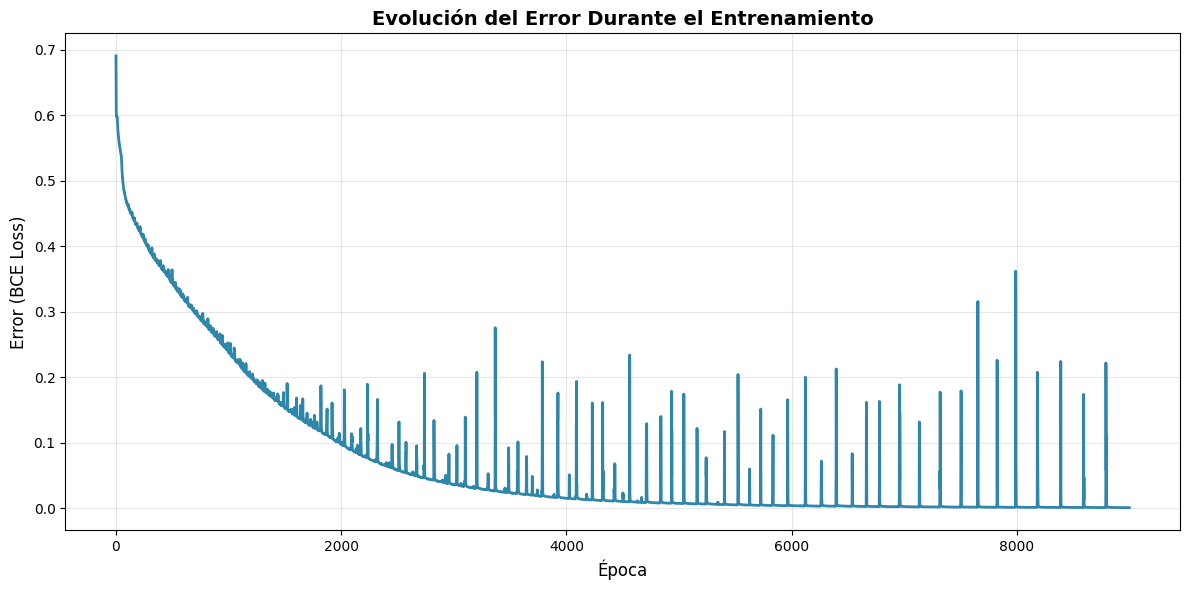

Error inicial: 0.690541
Error final: 0.000928
Reducción del error: 99.87%


In [103]:
# Graficar el error a través de las épocas
plt.figure(figsize=(12, 6))
plt.plot(history, linewidth=2, color='#2E86AB')
plt.title('Evolución del Error Durante el Entrenamiento', fontsize=14, fontweight='bold')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Error (BCE Loss)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Error inicial: {history[0]:.6f}")
print(f"Error final: {history[-1]:.6f}")
print(f"Reducción del error: {((history[0] - history[-1]) / history[0] * 100):.2f}%")

In [104]:
import matplotlib.pyplot as plt
def plot_latent_space(latent_representations, char_labels, title="Representación de 32 Patrones en el Espacio Latente (Z1 vs Z2)"):
    plt.figure(figsize=(12, 10))
    plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c='b', alpha=0.7)
    
    for i, label in enumerate(char_labels):
        plt.annotate(
            label, 
            (latent_representations[i, 0], latent_representations[i, 1]),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center'
        )

    plt.title(title)
    plt.xlabel("Z1")
    plt.ylabel("Z2")
    plt.grid(True)


C:\Users\juani\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


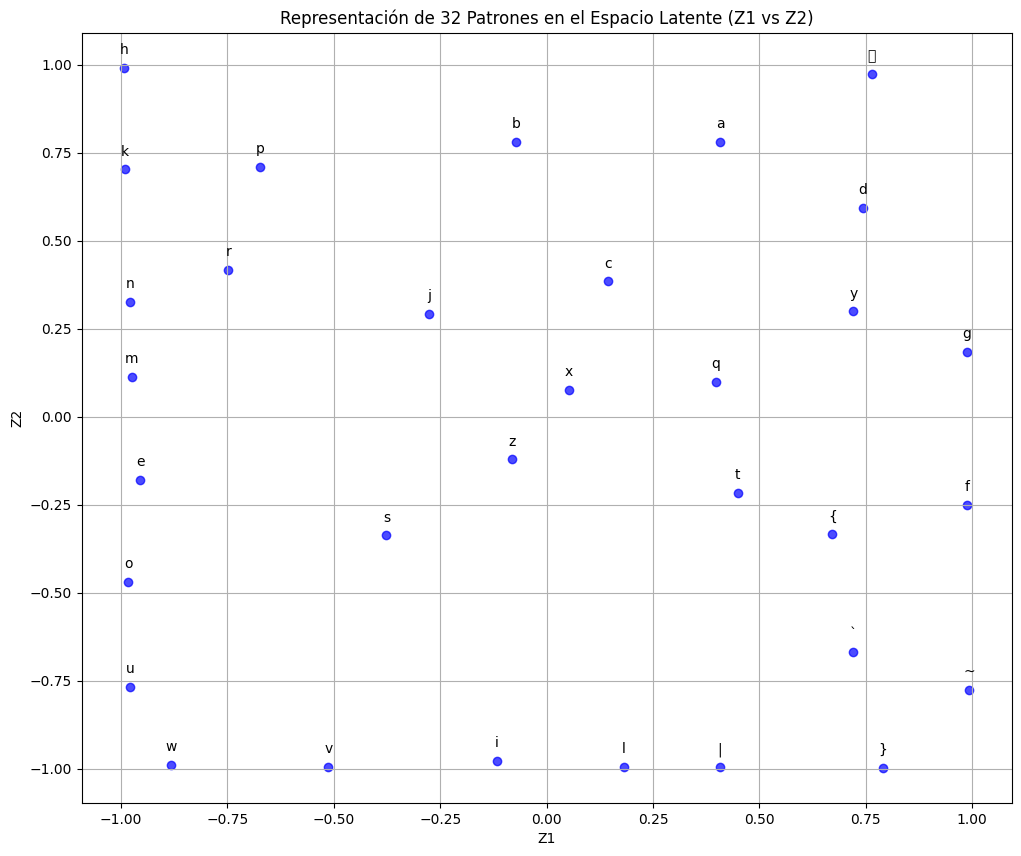

In [105]:
# Función para extraer el espacio latente (encoder)
def encode(autoencoder, x):
    """Pasa por las capas del encoder hasta el espacio latente"""
    output = x
    # Las primeras 4 capas son el encoder (Dense, Tanh, Dense, Tanh)
    for layer in autoencoder.layers[:4]:
        output = layer.forward(output)
    return output



# Extraer representaciones latentes
latent_representations = np.array([
    encode(autoencoder, x.reshape(-1, 1)).flatten() for x in X_train
])

# Visualizar espacio latente
plot_latent_space(latent_representations, char_labels)

In [106]:
# Dimensiones constantes para la visualización
HEIGHT = 7
WIDTH = 5

In [107]:
def count_incorrect_pixels(X_original, X_reconstructed):
    """
    Cuenta cuántos píxeles están incorrectos entre la imagen original y reconstruida.
    Redondea la reconstrucción a 0 o 1 antes de comparar.
    """
    X_recon_rounded = (X_reconstructed.flatten() > 0.5).astype(float)
    X_orig_flat = X_original.flatten()
    
    # Contar píxeles diferentes
    incorrect = np.sum(X_recon_rounded != X_orig_flat)
    return int(incorrect)

# Calcular píxeles incorrectos para cada letra
incorrect_pixels_per_char = []
for i in range(len(X_train)):
    X_original = X_train[i]
    X_reconstructed = autoencoder.forward(X_original.reshape(-1, 1))
    
    incorrect = count_incorrect_pixels(X_original, X_reconstructed)
    incorrect_pixels_per_char.append(incorrect)

# Mostrar estadísticas
print(f"Píxeles incorrectos por letra:")
for i, (label, incorrect) in enumerate(zip(char_labels, incorrect_pixels_per_char)):
    print(f"  {label}: {incorrect} píxeles incorrectos (de {INPUT_DIM})")

print(f"\nPromedio: {np.mean(incorrect_pixels_per_char):.2f} píxeles")
print(f"Total de letras perfectas (0 errores): {np.sum(np.array(incorrect_pixels_per_char) == 0)}/{len(X_train)}")

Píxeles incorrectos por letra:
  `: 0 píxeles incorrectos (de 35)
  a: 0 píxeles incorrectos (de 35)
  b: 0 píxeles incorrectos (de 35)
  c: 0 píxeles incorrectos (de 35)
  d: 0 píxeles incorrectos (de 35)
  e: 0 píxeles incorrectos (de 35)
  f: 0 píxeles incorrectos (de 35)
  g: 0 píxeles incorrectos (de 35)
  h: 0 píxeles incorrectos (de 35)
  i: 0 píxeles incorrectos (de 35)
  j: 0 píxeles incorrectos (de 35)
  k: 0 píxeles incorrectos (de 35)
  l: 0 píxeles incorrectos (de 35)
  m: 0 píxeles incorrectos (de 35)
  n: 0 píxeles incorrectos (de 35)
  o: 0 píxeles incorrectos (de 35)
  p: 0 píxeles incorrectos (de 35)
  q: 0 píxeles incorrectos (de 35)
  r: 0 píxeles incorrectos (de 35)
  s: 0 píxeles incorrectos (de 35)
  t: 0 píxeles incorrectos (de 35)
  u: 0 píxeles incorrectos (de 35)
  v: 0 píxeles incorrectos (de 35)
  w: 0 píxeles incorrectos (de 35)
  x: 0 píxeles incorrectos (de 35)
  y: 0 píxeles incorrectos (de 35)
  z: 0 píxeles incorrectos (de 35)
  {: 0 píxeles incorrect

C:\Users\juani\AppData\Local\Temp\ipykernel_20664\968997531.py:12: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\juani\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\juani\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


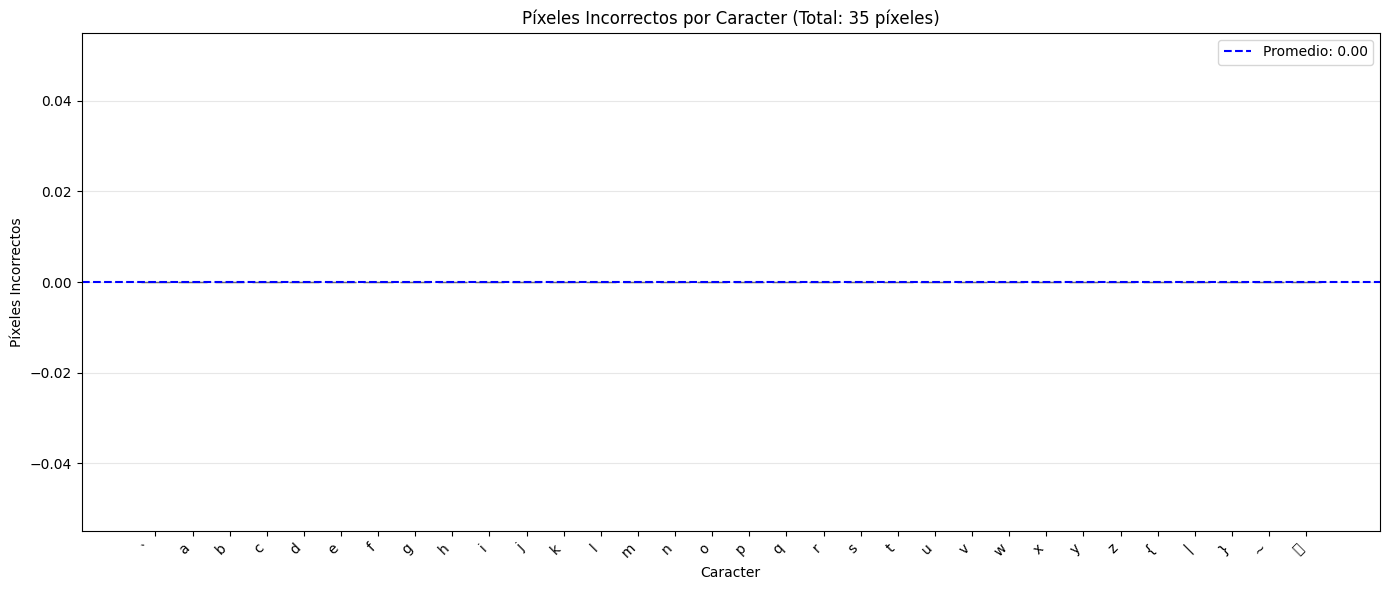

In [108]:
# Graficar píxeles incorrectos por letra
plt.figure(figsize=(14, 6))
plt.bar(range(len(char_labels)), incorrect_pixels_per_char, color='crimson', alpha=0.7, edgecolor='black')
plt.xticks(range(len(char_labels)), char_labels, rotation=45, ha='right')
plt.xlabel('Caracter')
plt.ylabel('Píxeles Incorrectos')
plt.title(f'Píxeles Incorrectos por Caracter (Total: {INPUT_DIM} píxeles)')
plt.axhline(y=np.mean(incorrect_pixels_per_char), color='blue', linestyle='--', 
            label=f'Promedio: {np.mean(incorrect_pixels_per_char):.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [109]:
# Función para decodificar desde el espacio latente
def decode(autoencoder, z):
    """Pasa por las capas del decoder desde el espacio latente"""
    output = z
    # Las últimas 4 capas son el decoder (Dense, Tanh, Dense, Sigmoid)
    for layer in autoencoder.layers[4:]:
        output = layer.forward(output)
    return output


C:\Users\juani\AppData\Local\Temp\ipykernel_20664\3592799638.py:34: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


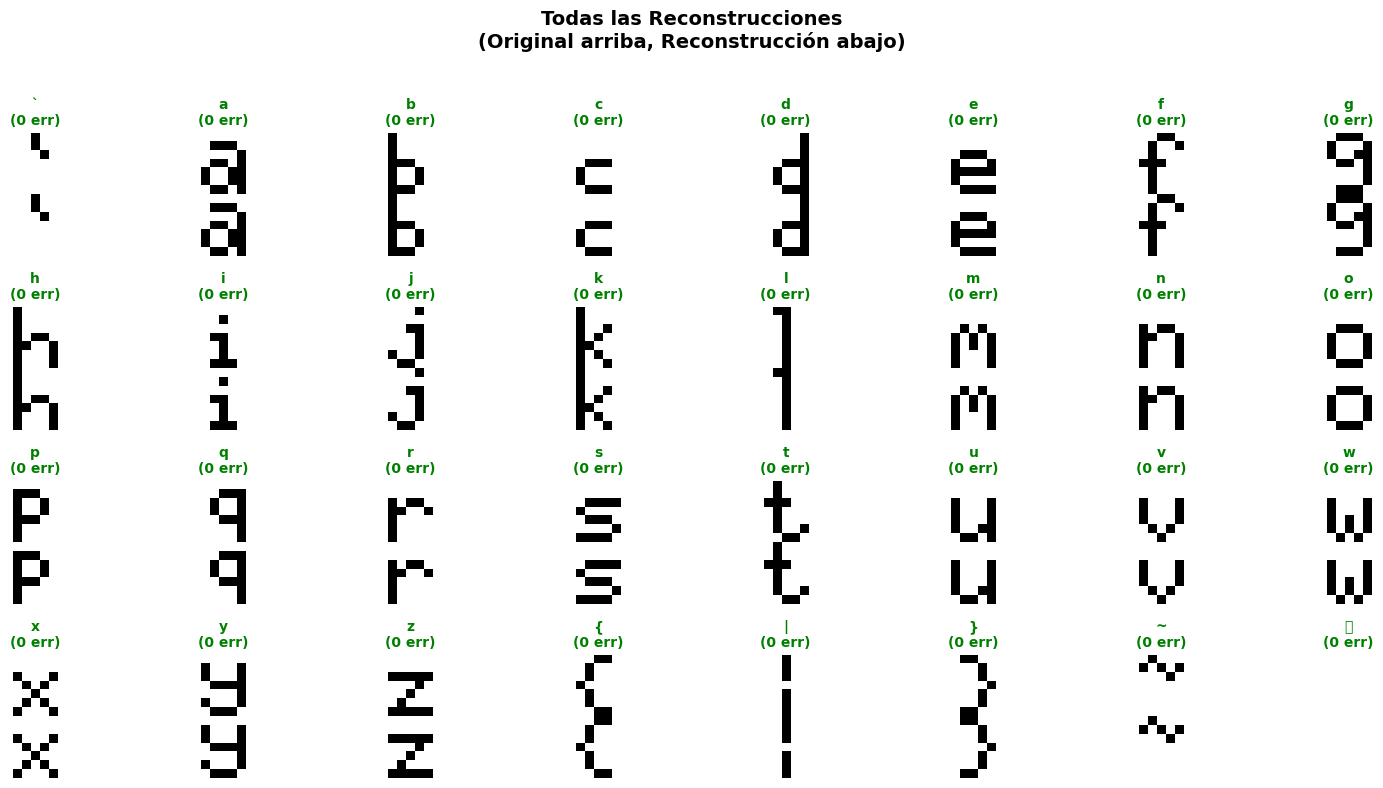


✅ Visualización completa:
   Total de caracteres: 32
   Caracteres perfectos (0 errores): 32
   Caracteres con ≤1 error: 32


In [110]:
# Mostrar todas las reconstrucciones en una cuadrícula
num_chars = len(X_train)
cols = 8  # 8 columnas
rows = (num_chars + cols - 1) // cols  # Calcular filas necesarias

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(X_train)):
    X_original = X_train[i]
    X_reconstructed = autoencoder.forward(X_original.reshape(-1, 1))
    X_recon_rounded = (X_reconstructed.flatten() > 0.5).astype(float)
    
    # Crear imagen combinada (original arriba, reconstrucción abajo)
    combined = np.vstack([
        X_original.reshape(HEIGHT, WIDTH),
        X_recon_rounded.reshape(HEIGHT, WIDTH)
    ])
    
    axes[i].imshow(combined, cmap='binary', interpolation='nearest')
    
    # Calcular píxeles incorrectos
    incorrect = count_incorrect_pixels(X_original, X_reconstructed)
    color = 'green' if incorrect == 0 else 'orange' if incorrect <= 1 else 'red'
    
    axes[i].set_title(f"{char_labels[i]}\n({incorrect} err)", fontsize=10, color=color, weight='bold')
    axes[i].axis('off')

# Ocultar ejes sobrantes
for i in range(len(X_train), len(axes)):
    axes[i].axis('off')

plt.suptitle("Todas las Reconstrucciones\n(Original arriba, Reconstrucción abajo)", fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(f"\n✅ Visualización completa:")
print(f"   Total de caracteres: {len(X_train)}")
print(f"   Caracteres perfectos (0 errores): {np.sum(np.array(incorrect_pixels_per_char) == 0)}")
print(f"   Caracteres con ≤1 error: {np.sum(np.array(incorrect_pixels_per_char) <= 1)}")

In [111]:
# Funciones modularizadas para visualización

def plot_interpolation_between_chars(char1_idx, char2_idx, alphas=[0.25, 0.5, 0.75], use_grayscale=False):
    """
    Visualiza la interpolación entre dos caracteres en el espacio latente.
    
    Args:
        char1_idx: Índice del primer carácter
        char2_idx: Índice del segundo carácter
        alphas: Lista de valores alpha para interpolación
        use_grayscale: Si True, usa escala de grises; si False, binariza
    """
    # Obtener representaciones latentes
    Z1 = encode(autoencoder, X_train[char1_idx].reshape(-1, 1))
    Z2 = encode(autoencoder, X_train[char2_idx].reshape(-1, 1))
    
    # Crear puntos interpolados
    Z_interps = [Z1 * (1 - alpha) + Z2 * alpha for alpha in alphas]
    
    # Crear figura con layout vertical
    fig = plt.figure(figsize=(14, 10))
    
    # Subgráfico 1: Espacio latente con los puntos interpolados
    ax1 = plt.subplot(2, 1, 1)
    ax1.scatter(latent_representations[:, 0], latent_representations[:, 1], 
               c='lightgray', alpha=0.3, s=50)
    ax1.scatter(Z1[0], Z1[1], c='blue', s=200, marker='o', edgecolors='black', 
               linewidths=2, label=f"'{char_labels[char1_idx]}'", zorder=5)
    ax1.scatter(Z2[0], Z2[1], c='red', s=200, marker='o', edgecolors='black', 
               linewidths=2, label=f"'{char_labels[char2_idx]}'", zorder=5)
    
    for i, (alpha, Z_interp) in enumerate(zip(alphas, Z_interps)):
        ax1.scatter(Z_interp[0], Z_interp[1], c='green', s=150, marker='s', 
                   edgecolors='black', linewidths=1.5, zorder=4)
        ax1.annotate(f'α={alpha}', (Z_interp[0], Z_interp[1]), 
                    textcoords="offset points", xytext=(0, -15), ha='center', 
                    fontsize=10, fontweight='bold')
    
    ax1.plot([Z1[0], Z2[0]], [Z1[1], Z2[1]], 'k--', alpha=0.3, linewidth=1.5)
    
    mode_str = "Escala de Grises" if use_grayscale else "Binarizado"
    ax1.set_title(f'Espacio Latente: Interpolación entre "{char_labels[char1_idx]}" y "{char_labels[char2_idx]}" ({mode_str})', 
                 fontsize=13, fontweight='bold')
    ax1.set_xlabel('Z1', fontsize=11)
    ax1.set_ylabel('Z2', fontsize=11)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Subgráfico 2: Decodificaciones
    decoded_chars = [decode(autoencoder, Z_interp) for Z_interp in Z_interps]
    
    # Preparar datos según el modo
    if use_grayscale:
        char_data = [
            (X_train[char1_idx], f"'{char_labels[char1_idx]}' (original)"),
            *[(decoded_chars[i].flatten(), f"α={alpha}") for i, alpha in enumerate(alphas)],
            (X_train[char2_idx], f"'{char_labels[char2_idx]}' (original)")
        ]
        cmap = 'gray_r'
    else:
        char_data = [
            (X_train[char1_idx], f"'{char_labels[char1_idx]}' (original)"),
            *[((decoded_chars[i].flatten() > 0.5).astype(float), f"α={alpha}") for i, alpha in enumerate(alphas)],
            (X_train[char2_idx], f"'{char_labels[char2_idx]}' (original)")
        ]
        cmap = 'binary'
    
    for idx, (char_img, title) in enumerate(char_data):
        ax_char = plt.subplot(2, len(char_data), idx + len(char_data) + 1)
        ax_char.imshow(char_img.reshape(HEIGHT, WIDTH), cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
        ax_char.set_title(title, fontsize=10, fontweight='bold')
        ax_char.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir información
    print(f"Interpolación {'con grises' if use_grayscale else 'binarizada'} entre '{char_labels[char1_idx]}' y '{char_labels[char2_idx]}'")
    print(f"Coordenadas latentes:")
    print(f"  '{char_labels[char1_idx]}': Z = [{Z1[0, 0]:.3f}, {Z1[1, 0]:.3f}]")
    print(f"  '{char_labels[char2_idx]}': Z = [{Z2[0, 0]:.3f}, {Z2[1, 0]:.3f}]")
    for alpha, Z_interp in zip(alphas, Z_interps):
        print(f"  α={alpha}: Z = [{Z_interp[0, 0]:.3f}, {Z_interp[1, 0]:.3f}]")


def plot_grid_sampling(grid_size=15, margin=0.5, use_grayscale=False):
    """
    Visualiza un grid sampling 2D del espacio latente.
    
    Args:
        grid_size: Tamaño de la grilla (grid_size x grid_size)
        margin: Margen adicional alrededor del rango de los datos
        use_grayscale: Si True, usa escala de grises; si False, binariza
    """
    # Determinar los rangos del espacio latente
    z1_min, z1_max = latent_representations[:, 0].min(), latent_representations[:, 0].max()
    z2_min, z2_max = latent_representations[:, 1].min(), latent_representations[:, 1].max()
    
    # Agregar margen
    z1_min, z1_max = z1_min - margin, z1_max + margin
    z2_min, z2_max = z2_min - margin, z2_max + margin
    
    # Crear grilla de muestreo
    z1_values = np.linspace(z1_min, z1_max, grid_size)
    z2_values = np.linspace(z2_min, z2_max, grid_size)
    
    # Crear figura
    fig = plt.figure(figsize=(18, 18))
    
    # Determinar colormap
    cmap = 'gray_r' if use_grayscale else 'binary'
    
    # Recorrer la grilla y decodificar cada punto
    for i, z2 in enumerate(z2_values):
        for j, z1 in enumerate(z1_values):
            # Crear punto en el espacio latente
            z_point = np.array([[z1], [z2]])
            
            # Decodificar
            decoded = decode(autoencoder, z_point)
            
            # Binarizar o mantener grises según configuración
            if use_grayscale:
                decoded_img = decoded.flatten()
            else:
                decoded_img = (decoded.flatten() > 0.5).astype(float)
            
            # Posición en la grilla (invertir i para que z2 crezca hacia arriba)
            ax = plt.subplot(grid_size, grid_size, (grid_size - 1 - i) * grid_size + j + 1)
            ax.imshow(decoded_img.reshape(HEIGHT, WIDTH), cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
            ax.axis('off')
    
    mode_str = "Escala de Grises" if use_grayscale else "Binarizado"
    plt.suptitle(f'Grid Sampling 2D del Espacio Latente - {mode_str} ({grid_size}x{grid_size})\n' + 
                 f'Z1: [{z1_min:.2f}, {z1_max:.2f}], Z2: [{z2_min:.2f}, {z2_max:.2f}]',
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    
    print(f"Grid sampling {'con grises' if use_grayscale else 'binarizado'} completado:")
    print(f"  Tamaño de grilla: {grid_size}x{grid_size} = {grid_size**2} puntos")
    print(f"  Rango Z1: [{z1_min:.3f}, {z1_max:.3f}]")
    print(f"  Rango Z2: [{z2_min:.3f}, {z2_max:.3f}]")

print("✅ Funciones de visualización modularizadas creadas:")

✅ Funciones de visualización modularizadas creadas:


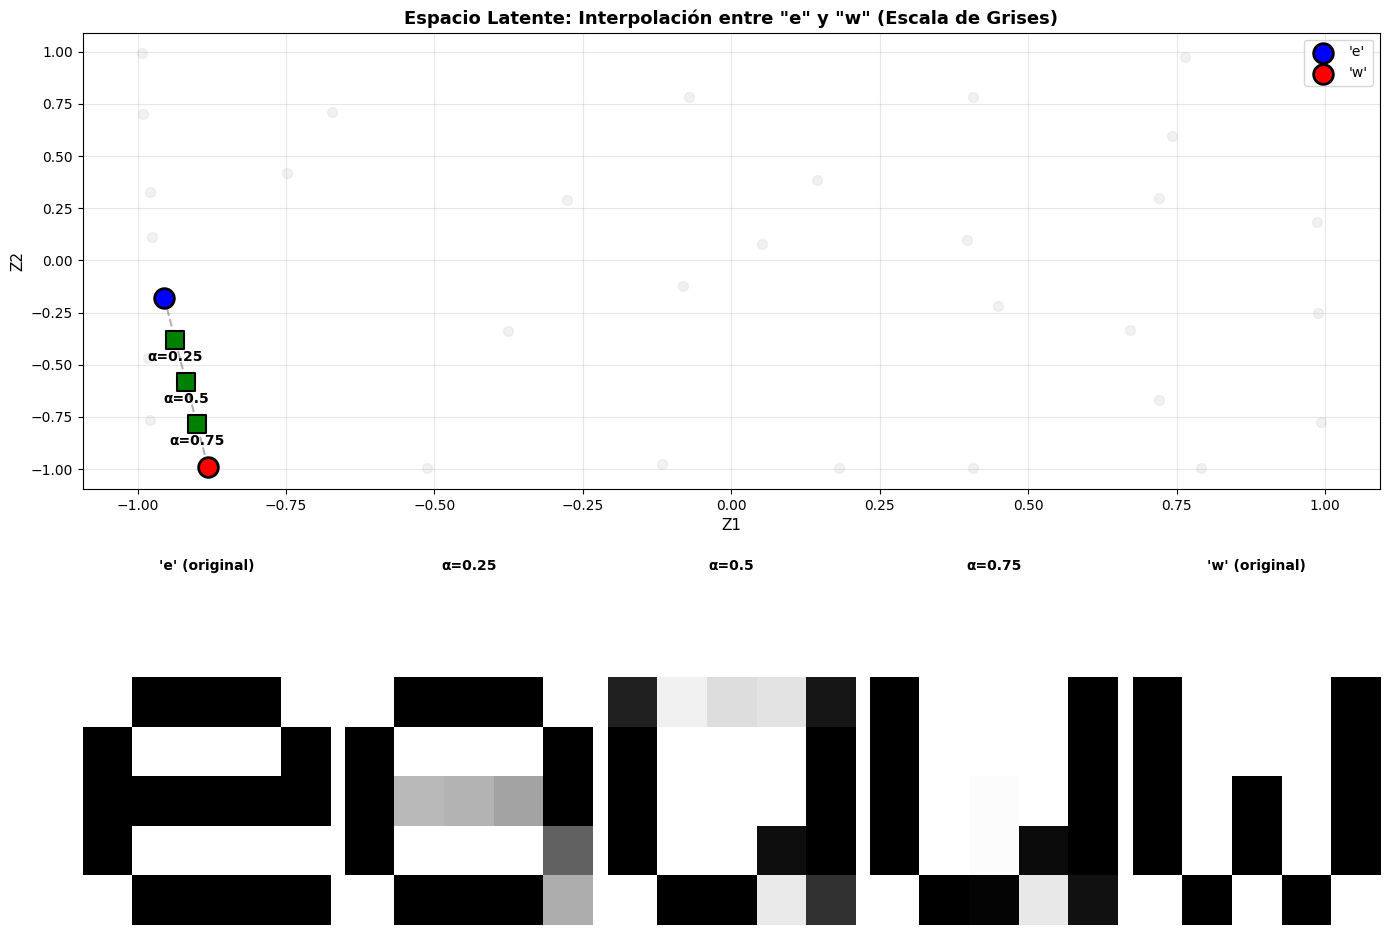

Interpolación con grises entre 'e' y 'w'
Coordenadas latentes:
  'e': Z = [-0.955, -0.179]
  'w': Z = [-0.882, -0.989]
  α=0.25: Z = [-0.937, -0.382]
  α=0.5: Z = [-0.918, -0.584]
  α=0.75: Z = [-0.900, -0.786]


In [112]:
# Interpolación entre 'e' y 'w' con escala de grises
plot_interpolation_between_chars(char1_idx=5, char2_idx=23, use_grayscale=True)

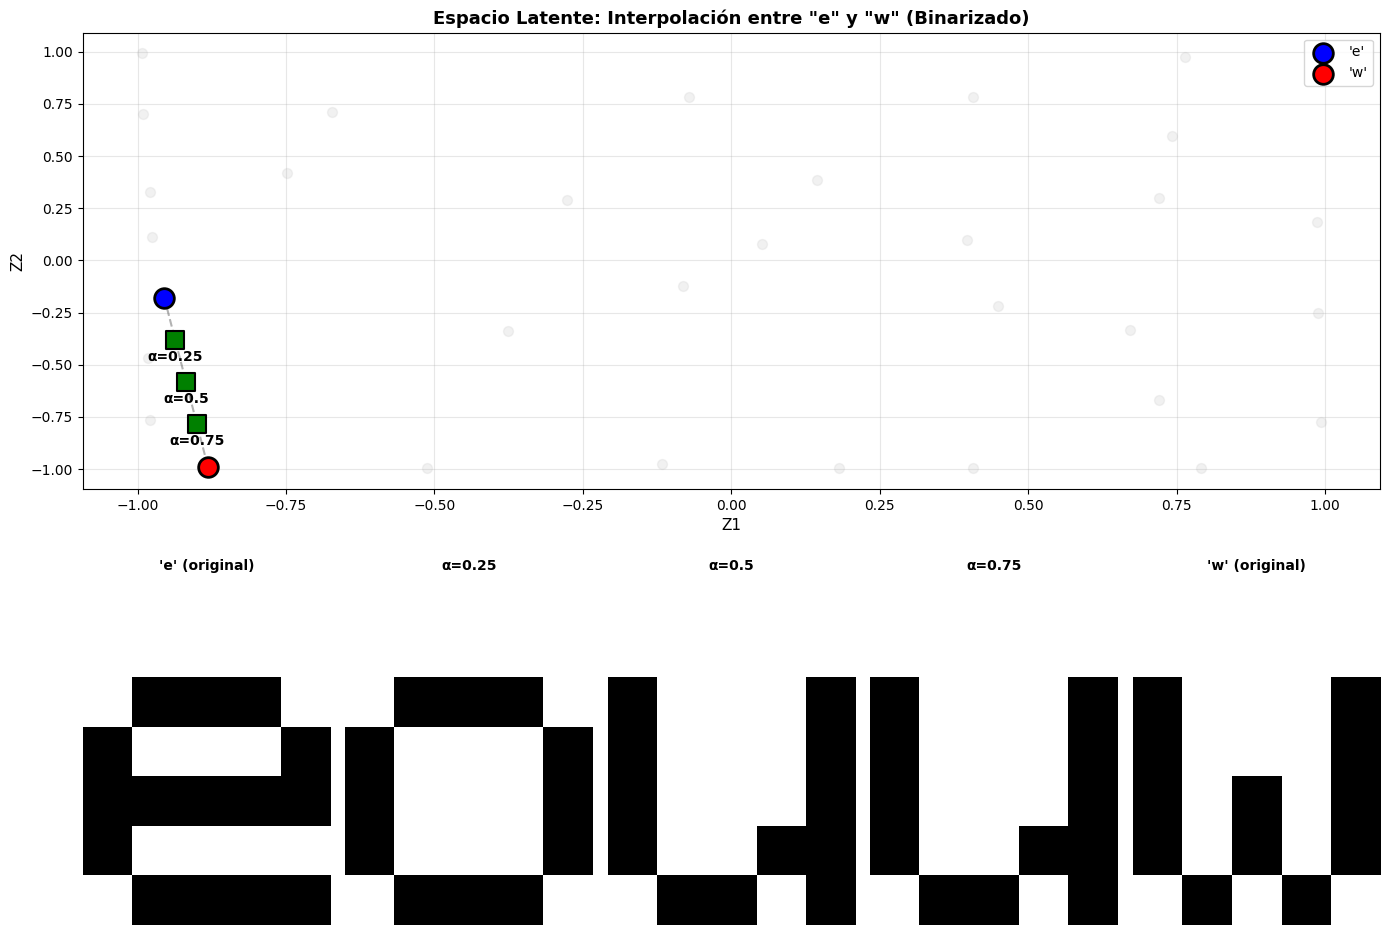

Interpolación binarizada entre 'e' y 'w'
Coordenadas latentes:
  'e': Z = [-0.955, -0.179]
  'w': Z = [-0.882, -0.989]
  α=0.25: Z = [-0.937, -0.382]
  α=0.5: Z = [-0.918, -0.584]
  α=0.75: Z = [-0.900, -0.786]


In [113]:
# Interpolación entre 'e' y 'w' binarizada (blanco/negro)
plot_interpolation_between_chars(char1_idx=5, char2_idx=23, use_grayscale=False)

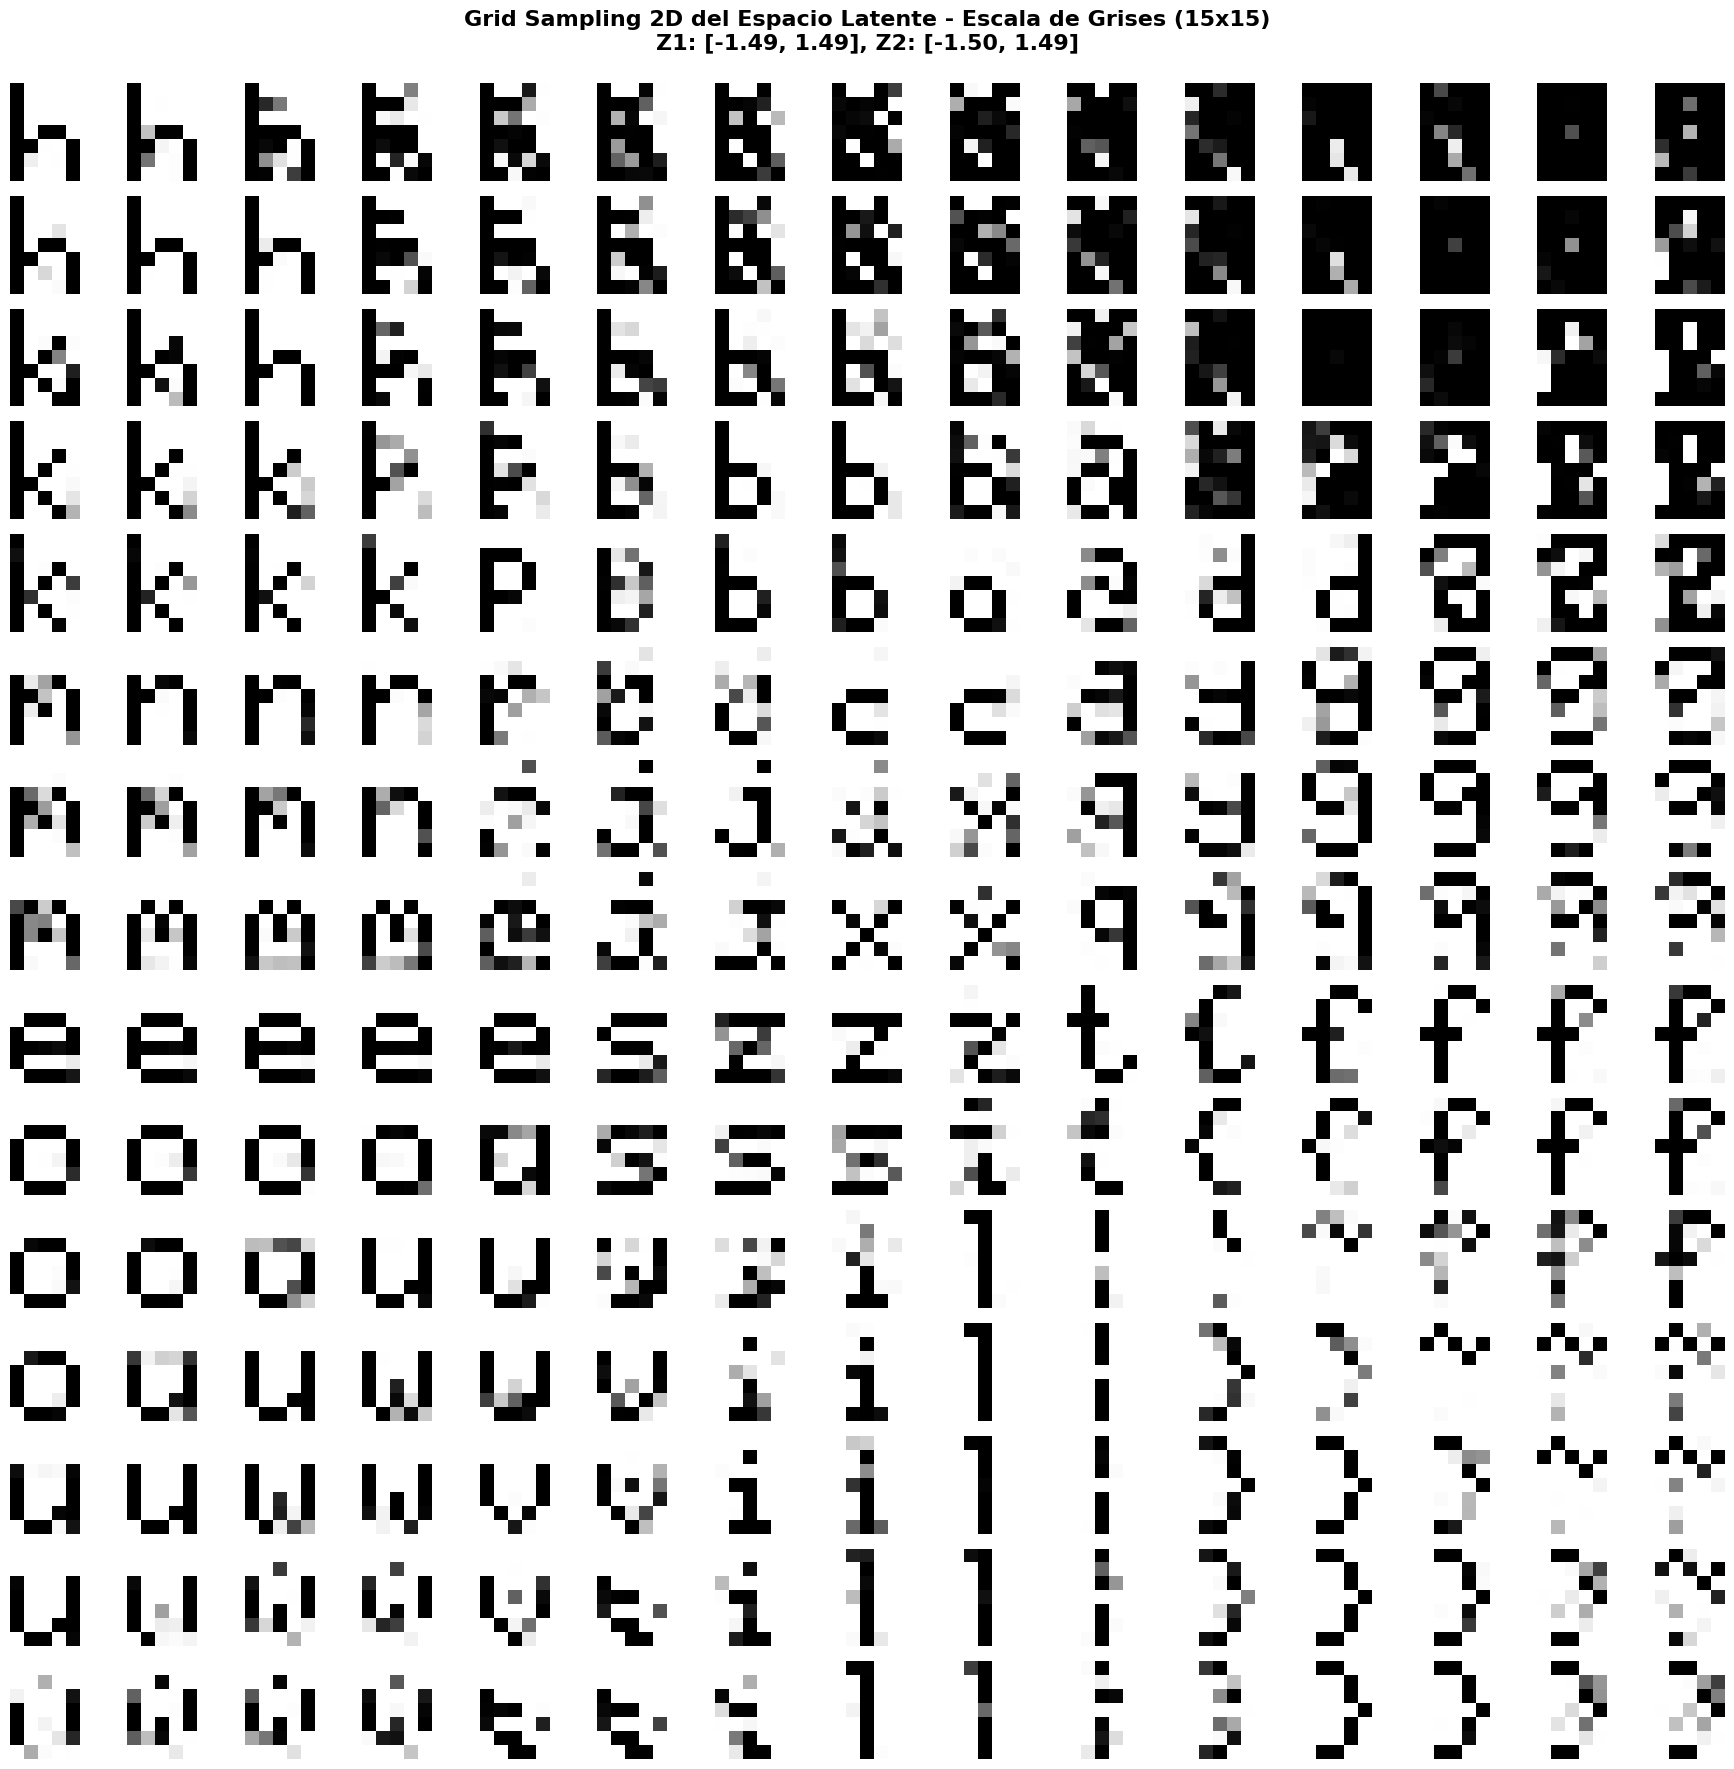

Grid sampling con grises completado:
  Tamaño de grilla: 15x15 = 225 puntos
  Rango Z1: [-1.493, 1.493]
  Rango Z2: [-1.497, 1.492]


In [114]:
# Grid Sampling 2D con escala de grises
plot_grid_sampling(grid_size=15, margin=0.5, use_grayscale=True)

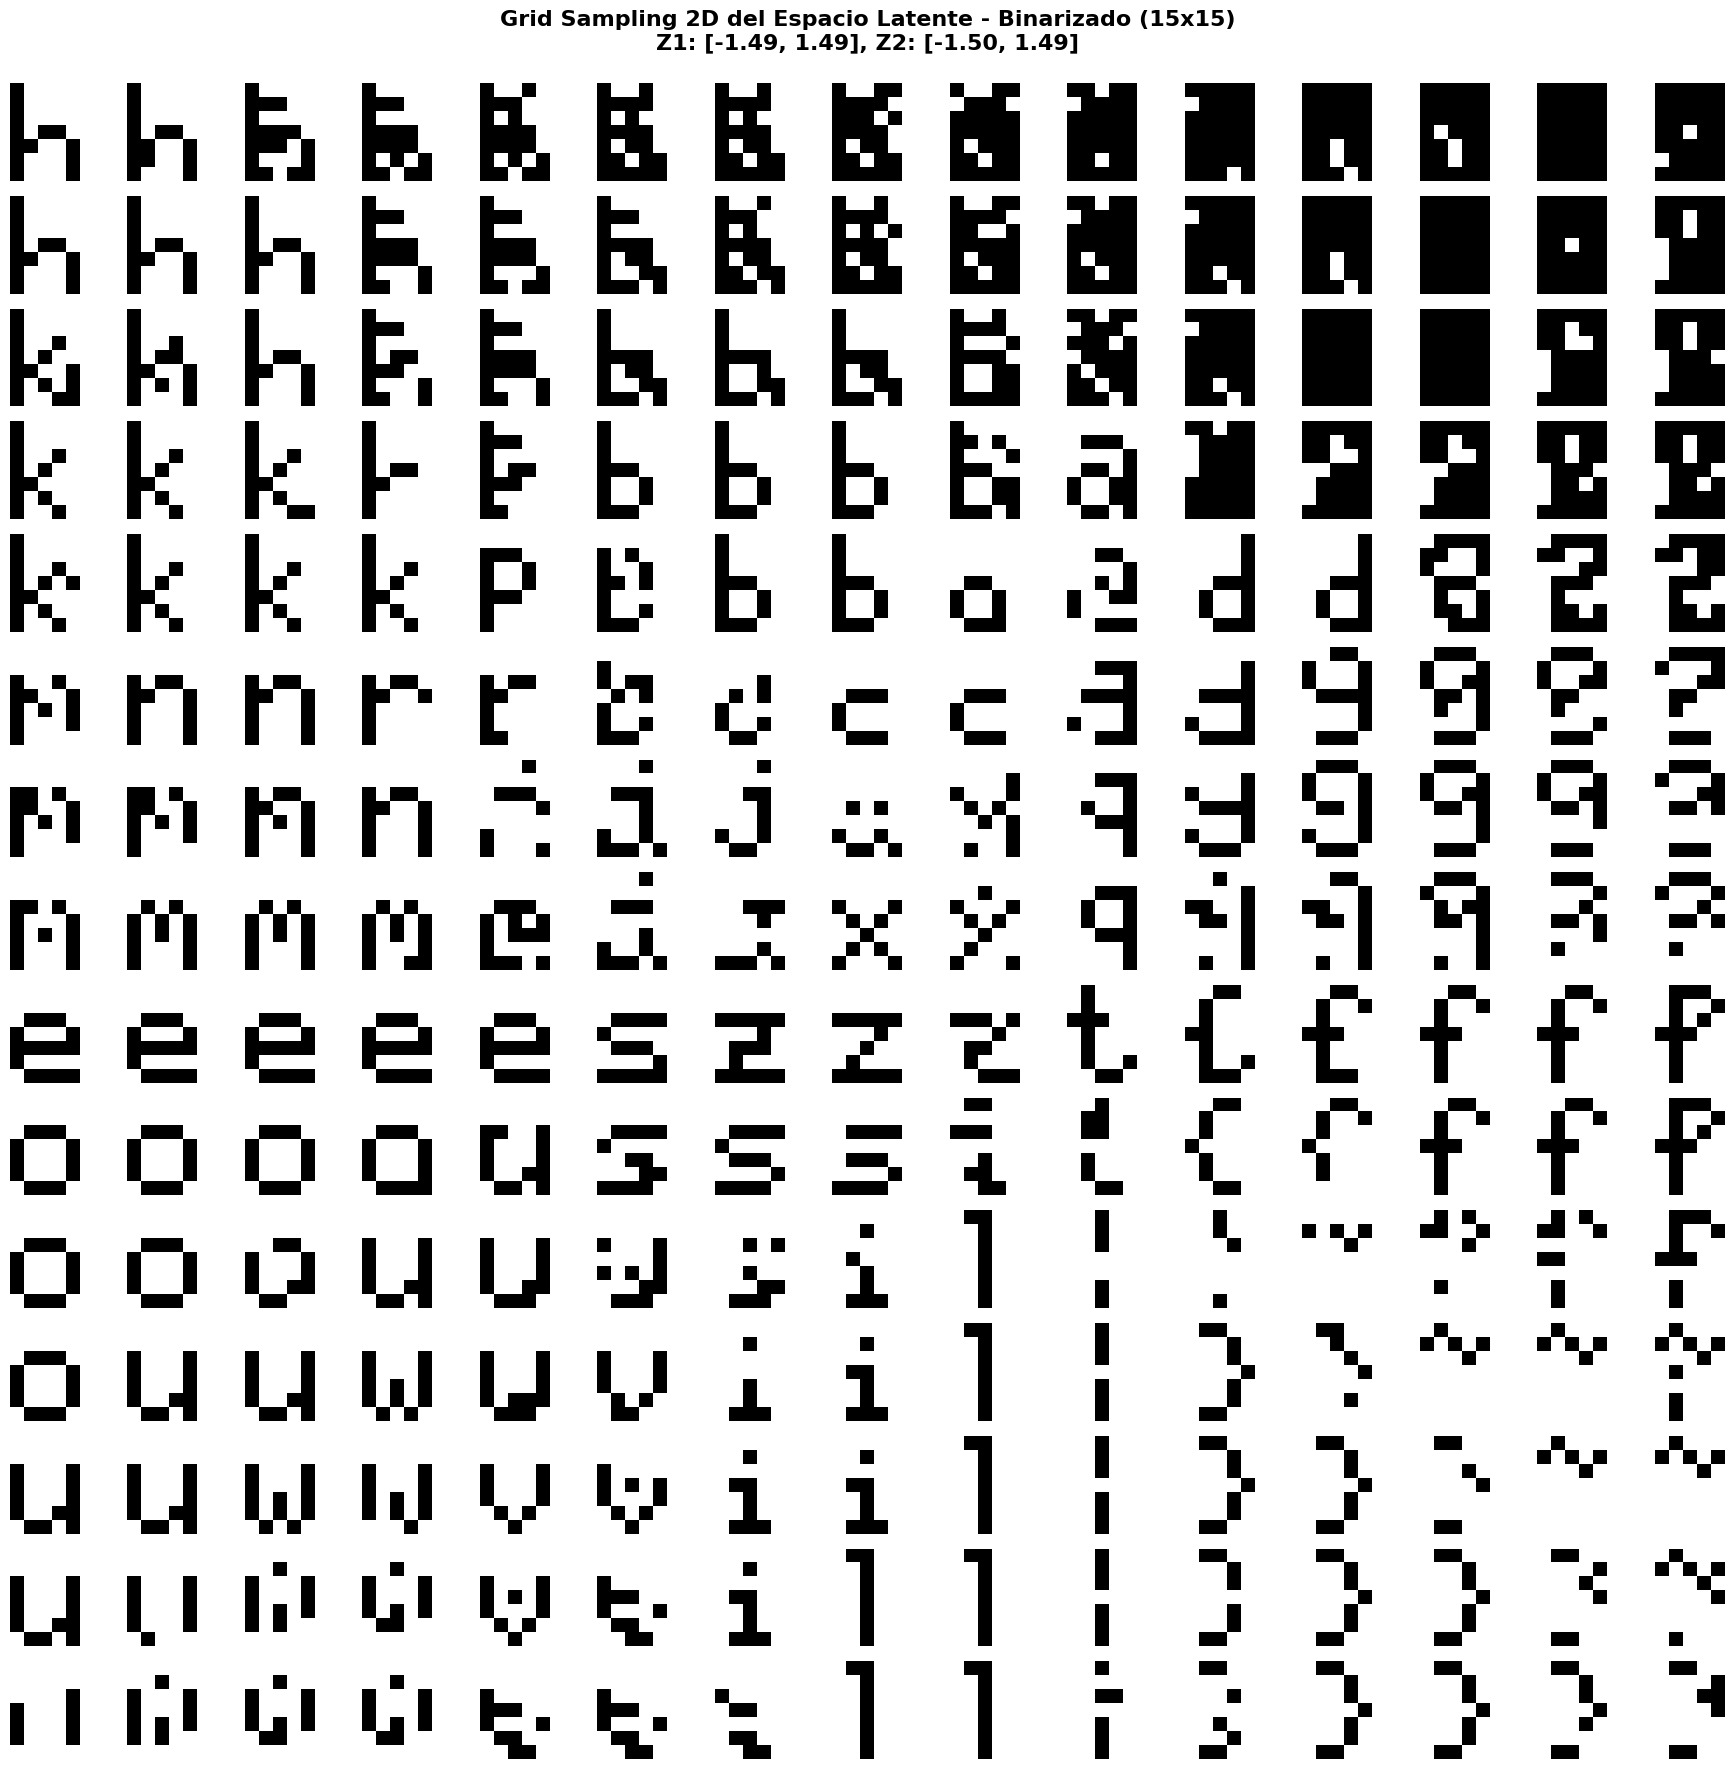

Grid sampling binarizado completado:
  Tamaño de grilla: 15x15 = 225 puntos
  Rango Z1: [-1.493, 1.493]
  Rango Z2: [-1.497, 1.492]


In [115]:
# Grid Sampling 2D binarizado (blanco/negro)
plot_grid_sampling(grid_size=15, margin=0.5, use_grayscale=False)